# 数据载入、存储及文件格式

本章重点关注使用pandas进行数据输入和输出。输入和输出通常有以下几种类型：
+ 读取文本文件及硬盘上其他更高效的格式文件
+ 从数据库载入文件
+ 与网络资源进行交互（比如Web API）

## 文本格式数据的读写

将表格型数据读取为DataFrame对象是pandas的重要性。下表总结了部分实现该功能的函数，read_csv和read_table可能是后期我们使用最多的函数。

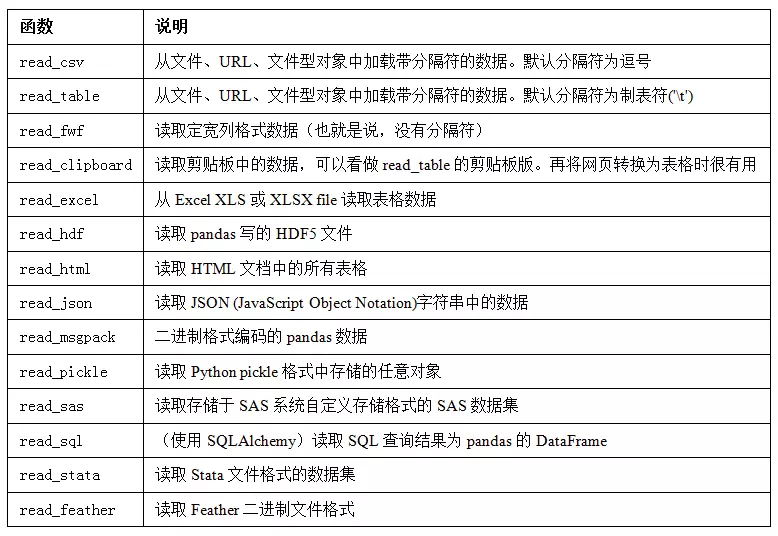

下面解释这些函数将文本数据转换为DataFrame的机制，这些函数的可选参数主要有一下几种类型：  
索引：

    可以将一或多个列作为返回的DataFrame，从文件或用户处获得列名，或者没有列名。
类型推断和数据转换：

    包括用户自定义的值转换和自定义的缺失值符号列表。
迭代：

    支持对大型文件的分块迭代。
未清洗数据问题：

    跳过行、页脚、注释以及其他次要数据，比如使用逗号分隔千位的数字。
因为工作中实际碰到的数据可能十分混乱，一些数据加载函数（尤其是read_csv）的选项逐渐变得复杂起来。面对不同的参数，感到头痛很正常（read_csv有超过50个参数）。pandas文档有这些参数的例子，如果你感到阅读某个文件很难，可以通过相似的足够多的例子找到正确的参数。

其中一些函数，比如pandas.read_csv，有类型推断功能，因为列数据的类型不属于数据类型。也就是说，你不需要指定列的类型到底是数值、整数、布尔值，还是字符串。其它的数据格式，如HDF5、Feather和msgpack，会在格式中存储数据类型。

日期和其他自定义类型的处理可能需要多花点工夫才行。首先我们来看一个以逗号分隔的（CSV）文本文件：

In [1]:
import pandas as pd
import numpy as np

In [2]:
#制作列名
#str_dir_ex1 = 'C:/Users/lenovo/data_of_python/examples/ex1.csv'

在Windows命令窗口下可以实现  
type C:\Users\lenovo\data_of_python\examples\ex1.csv

由于这个文件是逗号分隔的，我们可以使用read_csv将它读入一个DataFrame：

In [3]:
df = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex1.csv')
df

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


也可以使用read_table，但是要指定分隔符：

In [4]:
pd.read_table('C:/Users/lenovo/data_of_python/examples/ex1.csv',sep=',')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


有的文件并不包含表头行，要读取该文件，需要选择一些选项。比如自己制定列名

In [5]:
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex2.csv',header=None)

,0,1,2,3,4
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [6]:
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex2.csv', names=list('abcd')+['message'])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


可以将message列设置成为DataFrame的索引，只要将‘message’传给参数index_col或者指定位置4的列为索引：

In [7]:
names = list('abcd')+ ['message']
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex2.csv',names=names,index_col='message')

,a,b,c,d
message,,,,
hello,1,2,3,4
world,5,6,7,8
foo,9,10,11,12


令index_col=int有类似的功能

In [9]:
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex2.csv',names=names,index_col=4)

,a,b,c,d
message,,,,
hello,1,2,3,4
world,5,6,7,8
foo,9,10,11,12


从多个列种形成一个分层索引，需要传入一个包含序列号或列名的列表：如下所示：

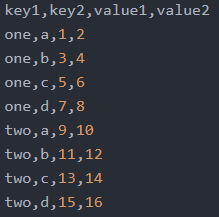

In [13]:
paresd = pd.read_csv('C:/Users/lenovo/data_of_python/examples/csv_mindex.csv',index_col=['key1','key2'])
paresd

value1  value2
key1 key2                
one  a          1       2
     b          3       4
     c          5       6
     d          7       8
two  a          9      10
     b         11      12
     c         13      14
     d         15      16

在某些情况下，一张表的分隔符并不是固定的，可能使用空白或其他方式来分隔字段。考虑如下文本文件：

In [20]:
list(open('C:/Users/lenovo/data_of_python/examples/ex3.txt'))

['            A         B         C\n',
 'aaa -0.264438 -1.026059 -0.619500\n',
 'bbb  0.927272  0.302904 -0.032399\n',
 'ccc -0.264273 -0.386314 -0.217601\n',
 'ddd -0.871858 -0.348382  1.100491\n']

上述文本以多种不同数量的空格分开，尽管我们可以手工处理，但是还可以**向read_table传入一个正则表达式作为分隔符**。在本例中，正则表达式为$\s+$，代码如下:
+ **利用正则表达式区分数据**

In [16]:
result = pd.read_table('C:/Users/lenovo/data_of_python/examples/ex3.txt',sep='\s+')
result

,A,B,C
aaa,-0.264438,-1.026059,-0.619500
bbb,0.927272,0.302904,-0.032399
ccc,-0.264273,-0.386314,-0.217601
ddd,-0.871858,-0.348382,1.100491


> 本例中，由于列名的数量比数据的列数少一个，因此read_table推断第一列应当作为DataFrame的索引。

解析函数有很多附加参数帮助我们处理各种发生异常的文件格式（表6-2列举了一部分）。

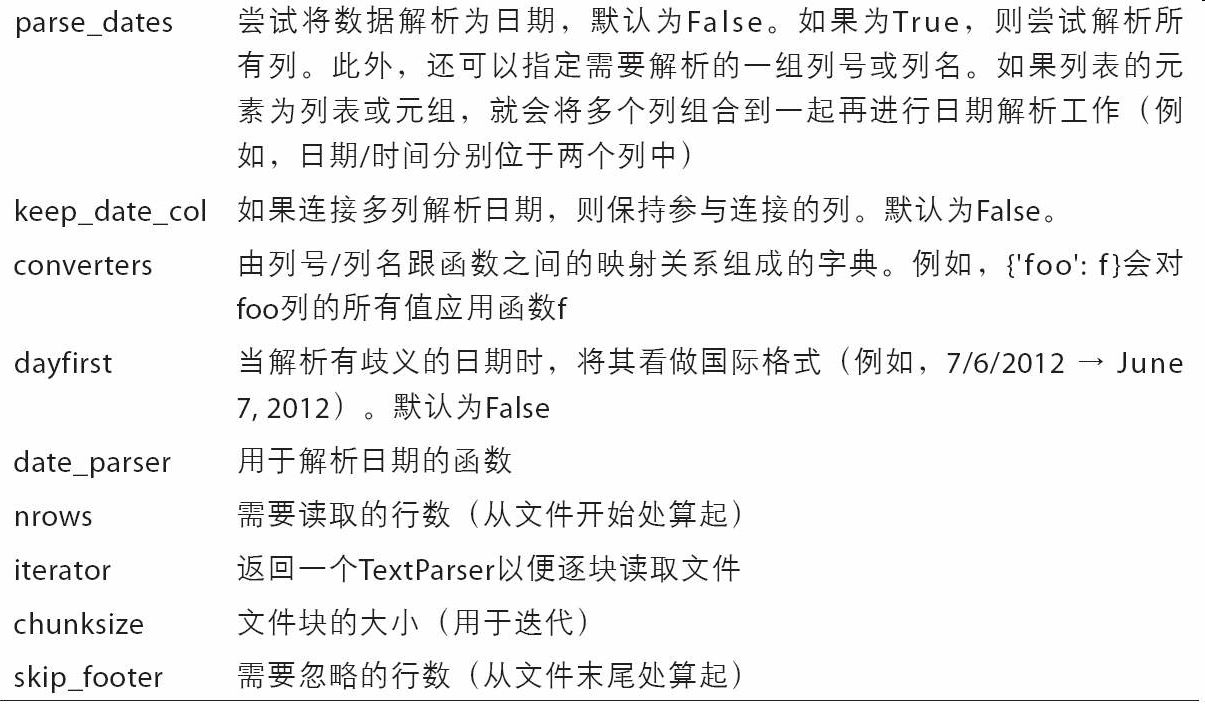

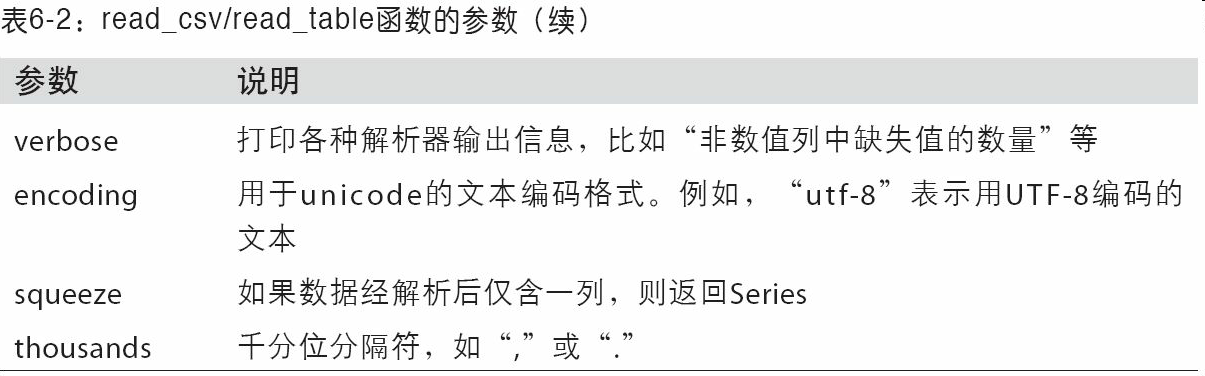

使用skiprows来跳过第一行、第三行和第四行：

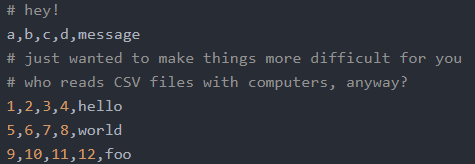

In [22]:
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex4.csv',skiprows=[0,2,3])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


缺失值处理是文件解析过程种一个重要且常常微妙的部分。通常情况下，缺失值要么不显示（空字符串），要么用一些标识值。默认情况下，pandas使用一些常见的标识，例如：NA和NULL:

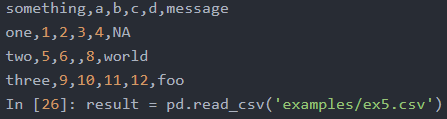

In [23]:
result = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex5.csv')
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [24]:
pd.isnull(result)

,something,a,b,c,d,message
0,False,False,False,False,False,True
1,False,False,False,True,False,False
2,False,False,False,False,False,False


na_values选项可以传入一个列表或一组字符串来指定缺失值：

In [25]:
result = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex5.csv',na_values=['NULL'])
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


**还可以对字典中的列指定不同的缺失值标记：**

In [26]:
sentinels = {'message':['foo','NA'],'something':['two']}
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex5.csv',na_values=sentinels)

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,NaN,5,6,NaN,8,world
2,three,9,10,11.0,12,NaN


### 分块读入文本文件

当处理大型文件或找出正确的参数集来正确的处理大文件时，我们就需要先读入文件的一个小片段或者按小块遍历文件。

在尝试大文件之前，可以先对pandas的显示设置进行调整，使之更为紧凑：

In [27]:
pd.options.display.max_rows = 10
result = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex6.csv')
result

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
...,...,...,...,...,...
9995,2.311896,-0.417070,-1.409599,-0.515821,L
9996,-0.479893,-0.650419,0.745152,-0.646038,E
9997,0.523331,0.787112,0.486066,1.093156,K
9998,-0.362559,0.598894,-1.843201,0.887292,G


如果只想读取一小部分行（避免读取整个文件），可以指明nrows：

In [28]:
pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex6.csv',nrows=5)

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q


为了分块读入文件，可以指定chunksize作为每一块的行数

In [29]:
chunker = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex6.csv',chunksize=1000)
chunker

read_csv返回的TextParser对象允许根据chunksize遍历文件。比如：可以遍历ex6.csv，并对’key'列聚合获得计数值：

In [21]:
chunker = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex6.csv',chunksize=1000)
tot = pd.Series([])
for piece in chunker:
    tot = tot.add(piece['key'].value_counts(), fill_value=0)
tot = tot.sort_values(ascending=False)
tot[:10]

1
2
3
4
5
6
7
8
9
10


> 注意：Series的对齐特性

TextParser还具有get_chunk方法，允许你按照任意大小读取数据快

### 将数据写入文本格式

数据可以导出为分隔的形式。

In [23]:
data = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex5.csv')
data

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


使用DataFrame的to_csv方法，可以将数据导出为逗号分隔的文件：

In [24]:
data.to_csv('C:/Users/lenovo/data_of_python/examples/out.csv')
pd.read_csv('C:/Users/lenovo/data_of_python/examples/out.csv')

,Unnamed: 0,something,a,b,c,d,message
0,0,one,1,2,3.0,4,NaN
1,1,two,5,6,NaN,8,world
2,2,three,9,10,11.0,12,foo


不仅只是逗号分隔符（sep=），其他的分隔符也是可以的（由于是写到sys.stdout，所以直接在console显示打印的我那本结果。

In [25]:
import sys
data.to_csv(sys.stdout,sep='|')

|something|a|b|c|d|message
0|one|1|2|3.0|4|
1|two|5|6||8|world
2|three|9|10|11.0|12|foo


缺失值在输出时以空字符出现。但也可以用其他标识符对缺失值进行标注（na_rep=）：

In [26]:
data.to_csv(sys.stdout, na_rep='NULL')

,something,a,b,c,d,message
0,one,1,2,3.0,4,NULL
1,two,5,6,NULL,8,world
2,three,9,10,11.0,12,foo


如果没有其他选项被指定的话，行和列的标签都会被写入。不过二者也都可以禁止写入：

In [28]:
data.to_csv(sys.stdout,index=False,header=False)

one,1,2,3.0,4,
two,5,6,,8,world
three,9,10,11.0,12,foo


也可以只写入列的子集，并且按照你选择的列和顺序写入：

In [31]:
data.to_csv(sys.stdout, index=False, columns=list('abc'))

a,b,c
1,2,3.0
5,6,
9,10,11.0


Series也有to_csv方法：

In [37]:
dates = pd.date_range('1/1/2000',periods=7)
ts = pd.Series(np.arange(7), index=dates)
ts.to_csv('C:/Users/lenovo/data_of_python/examples/tseries.csv')

### 使用分隔格式

绝大多数的**表型数据**都可以使用函数pandas.read_table从硬盘中读取。然而，在某些情况下，一些动手操作可能都是必不可少的。接收一个带有一行或多行错误的文件并不少见，read_table也无法解决这种情况。下面介绍一些基础工具。下面是ex7.csv的文本文件内容：

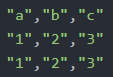

对于任何带有单子符分隔符的文件，可以使用Python的内建csv模块。要使用它，需要将任一打开的文件或文件型对象传给csv.reader:

In [38]:
import csv
f = open('C:/Users/lenovo/data_of_python/examples/ex7.csv')
reader = csv.reader(f)

像遍历文件那样遍历reader会产生元组，元组的值为删除了引号的字符：

In [39]:
for line in reader:
    print(line)

['a', 'b', 'c']
['1', '2', '3']
['1', '2', '3']


现在，为了使数据格式合乎要求，需要做一些整理工作。首先，读取文件到一个多行的列表中：

In [40]:
with open('C:/Users/lenovo/data_of_python/examples/ex7.csv') as f:
    lines = list(csv.reader(f))

然后，将数据拆分为列名和数据行：

In [41]:
header, values = lines[0], lines[1:]

In [42]:
header

['a', 'b', 'c']

In [43]:
values

[['1', '2', '3'], ['1', '2', '3']]

再然后，使用字典推导式和表达式$zip(*values)$生成一个包含数据列的字典，字典中行行转置成列：

In [44]:
data_dict = {h: v for h,v in zip(header, zip(*values))}
data_dict

{'a': ('1', '1'), 'b': ('2', '2'), 'c': ('3', '3')}

csv文件有多种不同风格。如果需要不同的分隔符、字符串引用约定或行终止符定义一种新的格式时，可以使用csv.Dialect定义一个简单的子类：

In [45]:
class my_dialect(csv.Dialect):
    lineterminator = '\n'
    delimiter = ';'
    quotechar = '"'
    quoting = csv.QUOTE_MINIMAL

In [46]:
f = open('C:/Users/lenovo/data_of_python/examples/ex7.csv')
reader = csv.reader(f,dialect=my_dialect)

或者不必定义子类，直接将csv语支参数以关键字传入给csv.reader：

In [47]:
reader = csv.reader(f, delimiter='|')

下表列出了csv.Dialect中的一些属性及其用途：

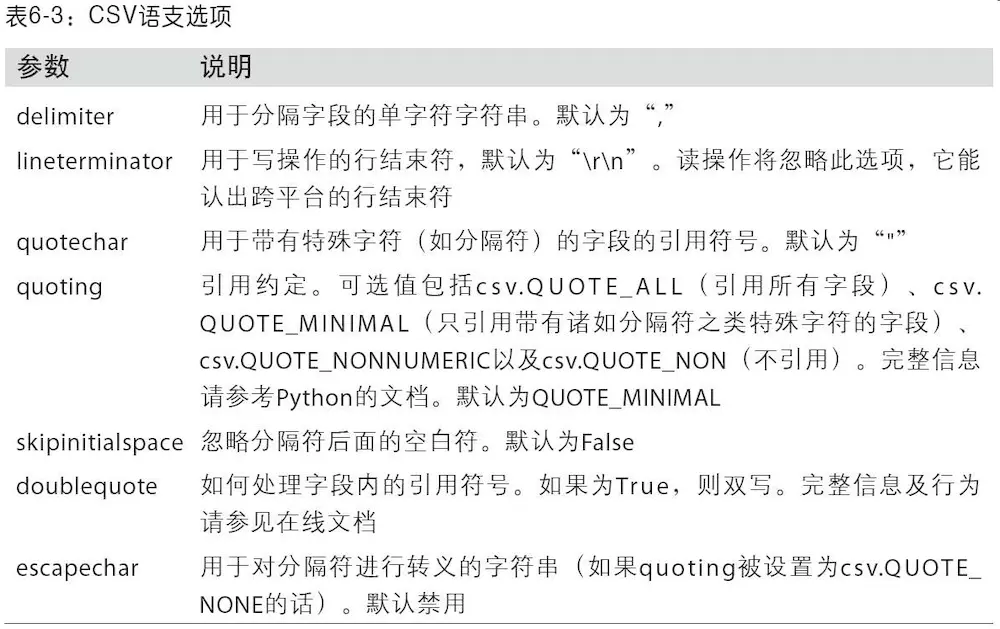

>对于那些使用复杂分隔符或多字符分隔符的文件，csv模块就无能为力了。这种情况下，你就只能使用字符串的split方法或正则表达式方法re.split进行行拆分和其他整理工作了。

需要动手写入被分隔的文件时，可以使用csv.writer。该函数接收一个已经打开的可写入文件对象以及和csv.reader相同的csv语支、格式选项：

In [48]:
with open('C:/Users/lenovo/data_of_python/examples/mydata.csv', 'w') as f:
    writer = csv.writer(f, dialect=my_dialect)
    writer.writerow(('one','two','three'))
    writer.writerow(('1','2','3'))
    writer.writerow(('4','5','6'))
    writer.writerow(('7','8','9'))

### JSON数据

JSON是（JavaScript Object Notation的简写）已经成为Web浏览器和其他应用间通过HTTP请求发送数据的标准格式。它是一种比CSV等表格文本形式更为自由的数据形式。下面是JSON格式的数据：

In [49]:
obj = '''
{"name": "Wes",
 "places_lived": ["United States", "Spain", "Germany"],
 "pet": null,
 "siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]},
              {"name": "Katie", "age": 38,
               "pets": ["Sixes", "Stache", "Cisco"]}]
}
'''

除去空值null和一些其他的细微差别（例如列表末尾不允许存在多余的逗号）之外，JSON非常接近于有效的Python代码。基本类型有对象（字典）、数组（列表）、字符串、数值、布尔值以及null。对象中所有的键都必须是字符串。许多Python库都可以读写JSON数据。我将使用json，因为它是构建于Python标准库中的。通过json.loads即可将JSON字符串转换成Python形式：

In [50]:
import json

In [51]:
result = json.loads(obj)
result

{'name': 'Wes',
 'places_lived': ['United States', 'Spain', 'Germany'],
 'pet': None,
 'siblings': [{'name': 'Scott', 'age': 30, 'pets': ['Zeus', 'Zuko']},
  {'name': 'Katie', 'age': 38, 'pets': ['Sixes', 'Stache', 'Cisco']}]}

> result 是数据类型是字典

另一方面，json.dumps可以将python对象转换回JSON：

In [52]:
asjson = json.dumps(result)

可以自己决定如何将（一个或一组）JSON对象转换为DataFrame或其他便于分析的数据结构。最简单方便的方式是：向DataFrame构造器传入一个包含字典的列表（就是原先的JSON对象），并选取数据字段的子集：

In [53]:
siblings = pd.DataFrame(result['siblings'],columns=['name','age'])
siblings

,name,age
0,Scott,30
1,Katie,38


pandas.read_json可以自动将JSON数据集按照指定次序转换为Series或DataFrame。下面是：JSON原文件

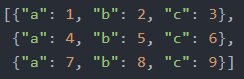

pandas.read_json的默认选项是假设JSON数组中的每个对象是表里的一行：

In [54]:
data = pd.read_json('C:/Users/lenovo/data_of_python/examples/example.json')
data

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


>第7章中关于USDA Food Database的那个例子进一步讲解了JSON数据的读取和处理（包括嵌套记录）。

使用to_json方法可以将Series和DataFrame中的数据导出为JSON：

In [55]:
print(data.to_json())

{"a":{"0":1,"1":4,"2":7},"b":{"0":2,"1":5,"2":8},"c":{"0":3,"1":6,"2":9}}


In [56]:
print(data.to_json(orient='records'))

[{"a":1,"b":2,"c":3},{"a":4,"b":5,"c":6},{"a":7,"b":8,"c":9}]


### XML和HTML：网络抓取

Python有许多可以读写常见的HTML和XML格式数据的库，包括lxml、Beautiful Soup和html5lib。lxml的速度比较快，但其它的库处理有误的HTML或XML文件更好。

pandas的内置函数read_html，它使用lxml和Beautiful Soup自动将HTML文件中的表格解析为DataFrame对象。为了进行展示，我从美国联邦存款保险公司下载了一个HTML文件（pandas文档中也使用过），它记录了银行倒闭的情况。首先，你需要安装read_html用到的库：

pandas.read_html有一些选项，默认条件下，它会搜索、尝试解析所有包含在 <table\>标签内的的表格数据，并返回一个包含DataFrame对象的列表：

In [57]:
tables = pd.read_html('C:/Users/lenovo/data_of_python/examples/fdic_failed_bank_list.html')
len(tables)

1

In [58]:
failures = tables[0]
failures.head()

,Bank Name,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date
0,Allied Bank,Mulberry,AR,91,Today's Bank,"September 23, 2016","November 17, 2016"
1,The Woodbury Banking Company,Woodbury,GA,11297,United Bank,"August 19, 2016","November 17, 2016"
2,First CornerStone Bank,King of Prussia,PA,35312,First-Citizens Bank & Trust Company,"May 6, 2016","September 6, 2016"
3,Trust Company Bank,Memphis,TN,9956,The Bank of Fayette County,"April 29, 2016","September 6, 2016"
4,North Milwaukee State Bank,Milwaukee,WI,20364,First-Citizens Bank & Trust Company,"March 11, 2016","June 16, 2016"


#### 使用lxml.objectify解析XML

XML（eXtensible Markup Language）是另一种常用的结构化数据格式，它使用与数据支持分层、嵌套数据。

前面，我介绍了pandas.read_html函数，它使用lxml或Beautiful Soup从HTML解析数据。XML和HTML的结构很相似，但XML更为通用。下面，用一个例子演示如何利用lxml从XML格式解析数据。

纽约大都会运输署发布了一些有关其公交和列车服务的数据资料 ( http://www.mta.info/developers/download.html \)。这里，我们将看看包含在一组XML文件中的运行情况数据。每项列车或公交服务都有各自的文件（例如地铁-被铁路的文件是Performance_MNR.xml），其中每条XML记录就是一条月度数据，如下所示：

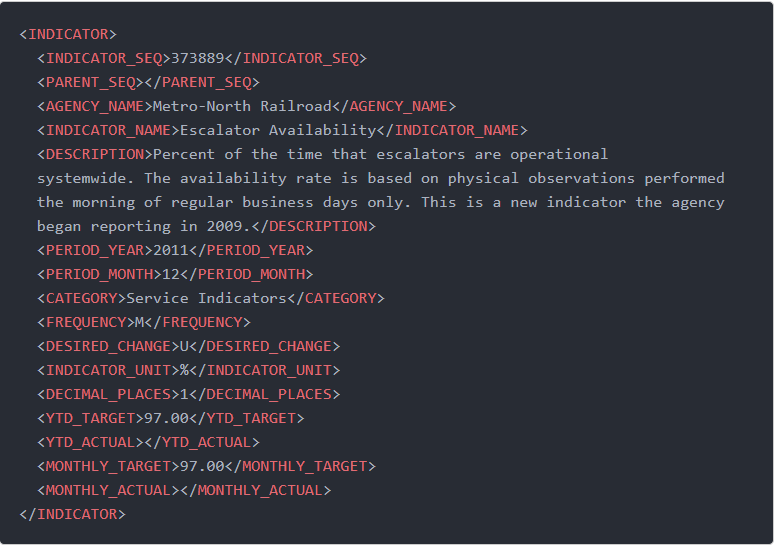

使用lxml.objectify，可以解析这个文件，并用getroot来获得XML文件的根节点的引用：

In [59]:
from lxml import objectify

In [60]:
path = 'C:/Users/lenovo/data_of_python/examples/mta_perf/Performance_MNR.xml'
parsed = objectify.parse(open(path))
root = parsed.getroot()

root.INDICATOR返回一个用于产生每个<INDICATOR\>XML元素的生成器。对于每条记录，我们可以用标记名（如YTD_ACTUAL）和数据值填充一个字典（排除几个标记）：

In [61]:
data = []
skip_fields = ['PARENT_SEQ','INDICATOR_SEQ','DESIRED_CHANGE','DECIMAL_PLACES']
for elt in root.INDICATOR:
    el_data = {}
    for child in elt.getchildren():
        if child.tag in skip_fields:
            continue
        el_data[child.tag] = child.pyval
    data.append(el_data)

最后，将这组字典转换为一个DataFrame：

In [62]:
perf = pd.DataFrame(data)
perf.head()

,AGENCY_NAME,CATEGORY,DESCRIPTION,FREQUENCY,INDICATOR_NAME,INDICATOR_UNIT,MONTHLY_ACTUAL,MONTHLY_TARGET,PERIOD_MONTH,PERIOD_YEAR,YTD_ACTUAL,YTD_TARGET
0,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,1,2008,96.9,95
1,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95,95,2,2008,96,95
2,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,96.9,95,3,2008,96.3,95
3,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,98.3,95,4,2008,96.8,95
4,Metro-North Railroad,Service Indicators,Percent of commuter trains that arrive at thei...,M,On-Time Performance (West of Hudson),%,95.8,95,5,2008,96.6,95


XML数据可以比例子更复杂。每个标签也可以包含数据。考虑一个HTML连接标签，也是有效的XML：

In [63]:
from io import StringIO
tag = '<a href="http://www.google.com">Google</a>'
root = objectify.parse(StringIO(tag)).getroot()

现在可以访问标签或链接文本中的任何字段（如：href）：

In [64]:
root

<Element a at 0x132779c0fc8>

In [65]:
root.get('href')

'http://www.google.com'

In [66]:
root.text

'Google'

## 二进制格式

实现数据的高效二进制格式存储最简单的办法之一是使用Python内置的pickle序列化。同时，pandas对象都有一个用于将数据以pickle格式保存到磁盘上的to_pickle方法：

In [67]:
frame = pd.read_csv('C:/Users/lenovo/data_of_python/examples/ex1.csv')
frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


In [68]:
frame.to_pickle('C:/Users/lenovo/data_of_python/examples/frame_pickle')

可以直接使用内建的pickle读取文件中的“pickle化”的对象那个，或更方便地使用pandas.readd_pickle：

In [69]:
pd.read_pickle('C:/Users/lenovo/data_of_python/examples/frame_pickle')

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


>注意：pickle仅建议用于短期存储格式。其原因是很难保证该格式永远是稳定的；今天pickle的对象可能无法被后续版本的库unpickle出来。虽然我们尽力保证这种事情不会发生在pandas中，但是今后的某个时候说不定还是得“打破”该pickle格式。

pandas内置支持两个二进制数据格式：HDF5和MessagePack。下一节给出几个HDF5的例子。pandas或NumPy数据的其它存储格式有：
+ bcolz：
    
        一种可压缩的列存储二进制格式，基于Blosc压缩库。
+ Feather：

        R语言社区的Hadley Wickham设计的一种跨语言的列存储文件格式；
        Feather使用了Apache Arrow的列式内存格式。

### 使用HDF5格式

HDF5是一种存储大规模科学数组数据的非常好的文件格式。它可以被作为C标准库，带有许多语言的接口，如Java、Python和MATLAB等。HDF5中的HDF指的是层次型数据格式（hierarchical data format）。每个HDF5文件都含有一个文件系统式的节点结构，它使你能够存储多个数据集并支持元数据。与其他简单格式相比，HDF5支持多种压缩器的即时压缩，还能更高效地存储重复模式数据。对于那些非常大的无法直接放入内存的数据集，HDF5就是不错的选择，因为它可以高效地分块读写。

虽然可以用PyTables或h5py库直接访问HDF5文件，pandas提供了更为高级的接口，可以简化存储Series和DataFrame对象。HDFStore类可以像字典一样，处理低级的细节：

In [70]:
frame = pd.DataFrame({'a':np.random.randn(100)})
store = pd.HDFStore('C:/Users/lenovo/data_of_python/examples/mydata.h5')
store['obj1'] = frame
store['obj1_col'] = frame['a']
store

<class 'pandas.io.pytables.HDFStore'>
File path: C:/Users/lenovo/data_of_python/examples/mydata.h5

包含在HDF5文件中的对象可以使用相同的字典型API进行检索：

In [71]:
store['obj1']

,a
0,-0.235645
1,-0.133379
2,0.159588
3,1.136649
4,-0.766775
...,...
95,0.217652
96,2.615081
97,0.220806
98,0.042363


HDFStore支持两种存储模式，'fixed'和'table'。后者通常会更慢，但是支持使用特殊语法进行查询操作：

In [72]:
store.put('obj2',frame,format='table')
store.select('obj2', where=['index >= 10 and index <= 15'])

,a
10,0.034394
11,1.160696
12,1.382227
13,0.112609
14,-0.198568
15,0.225858


put是store['obj2'] = frame方法的显示版本，允许我们设置其它的选项，比如存储格式。

pandas.read_hdf函数是这些工具的快捷方法：

In [73]:
frame.to_hdf('C:/Users/lenovo/data_of_python/examples/mydata.h5','obj3',format='table')
pd.read_hdf('C:/Users/lenovo/data_of_python/examples/mydata.h5','obj3',where=['index < 5'])

ValueError: The file 'C:/Users/lenovo/data_of_python/examples/mydata.h5' is already opened, but not in read-only mode (as requested).

>如果你要处理的数据位于远程服务器，比如Amazon S3或HDFS，使用专门为分布式存储（比如Apache Parquet）的二进制格式也许更加合适。Python的Parquet和其它存储格式还在不断的发展之中，所以这本书中没有涉及。

如果需要本地处理海量数据，我建议你好好研究一下PyTables和h5py，看看它们能满足你的哪些需求。。由于许多数据分析问题都是IO密集型（而不是CPU密集型），利用HDF5这样的工具能显著提升应用程序的效率。

>HDF5不是数据库。它最适合用作“一次写多次读”的数据集。虽然数据可以在任何时候被添加到文件中，但如果同时发生多个写操作，文件就可能会被破坏。

### 读取Microsoft Excel 文件

pandas也支持通过ExcelFile类或pandas.read_excel的函数来读取存储在Excel 2003（或更高版本）文件中的表格型数据。这些工具内部是使用附加包xlrd和openpyxl来分别读取XLS和XLSX文件的的。可以使用pip或conda手动安装这些工具。

使用ExcelFile时，通过将xls或xlsx的路径传入，生成一个实例，存储在表中的数据可以通过pandas.read_excel读取DataFrame中：

In [ ]:
xlsx = pd.ExcelFile('C:/Users/lenovo/data_of_python/examples/ex1.xlsx')
pd.read_excel(xlsx, 'Sheet1')

如果读取的是含有多个表中的文件，生成ExcelFile更快，但也可以更简洁地将文件名传入pandas.read_excel：

In [ ]:
frame = pd.read_excel('C:/Users/lenovo/data_of_python/examples/ex1.xlsx', 'Sheet1')
frame

需要将pandas数据写入到Excel格式中，你必须先生成一个ExcelWriter，然后使用pandas对象的to_excel方法将数据写入：

In [ ]:
writer = pd.ExcelWriter('C:/Users/lenovo/data_of_python/examples/ex2.xlsx')
frame.to_excel(writer, 'Sheet1')
writer.save()

也可以将文件路径传递给to_excel，避免直接调用ExcelWriter：

In [ ]:
frame.to_excel('C:/Users/lenovo/data_of_python/examples/ex2.xlsx')

## 与 Web API 交互

许多网站都有一些通过JSON或其他格式提供数据的公开API。通过Python访问这些API的办法有不少。一个简单易用的办法（推荐）是requests包(<http://docs.python-requests.org>)。

要获取Github上最新的30条关于pandas的问题，可以使用附加库requests发送一个HTTP GET请求：

In [ ]:
import requests

In [ ]:
url = 'https://api.github.com/repos/pandas-dev/pandas/issues'
resp = requests.get(url)
resp

Response(响应)对象的json方法将返回一个包含解析为本地Python对象的JSON的字典：

In [ ]:
data = resp.json()
data[0]['title']

data中的每个元素都是一个包含GitHub问题页面上的所有数据的字典（除注释外）。  
可以将data直接传给DataFrame，并提取感兴趣的字段：

In [ ]:
issues = pd.DataFrame(data, columns=['number','title','labels','state'])
issues

>通过一些复杂操作，你可以创建一些更高阶的接口来访问常用的Web API，以返回DataFrame对象以便与分析。

## 与数据库交互

在商业场景下，大多数数据可能不是存储在文本或Excel文件中。基于SQL的关系型数据库（如SQL Server、PostgreSQL和MySQL等）使用非常广泛，其它一些数据库也很流行。数据库的选择通常取决于性能、数据完整性以及应用程序的伸缩性需求。

将数据从SQL加载到DataFrame的过程很简单，此外pandas还有一些能够简化该过程的函数。例如，我将使用SQLite数据库（通过Python内置的sqlite3驱动器）：

In [ ]:
import sqlite3

In [ ]:
query = """
        CREATE TABLE test_1
        (a VARCHAR(20), b VARCHAR(20), c REAL, d INTEGER);"""

In [ ]:
con = sqlite3.connect('C:/Users/lenovo/data_of_python/examples/mydata.sqlite')

In [ ]:
con.execute(query)

In [ ]:
con.commit()

再插入几行数据：

In [ ]:
data = [('Atlanta', 'Georgia', 1.25, 6),
        ('Tallahassee', 'Florida', 2.6, 3),
        ('Sacramento', 'California', 1.7, 5)]

In [ ]:
stmt = "INSERT INTO test_1 VALUES(?,?,?,?)"

In [ ]:
con.executemany(stmt, data)

In [10]:
con.commit()

当从数据库的表中选择数据时，大部分Python的SQL驱动（PyDOBC、psycopg、MySQLdb、pymssql等）返回的是元组的列表：

In [78]:
cursor = con.execute('select * from test_1')
rows = cursor.fetchall()
rows

[('Atlanta', 'Georgia', 1.25, 6),
 ('Tallahassee', 'Florida', 2.6, 3),
 ('Sacramento', 'California', 1.7, 5),
 ('Atlanta', 'Georgia', 1.25, 6),
 ('Tallahassee', 'Florida', 2.6, 3),
 ('Sacramento', 'California', 1.7, 5)]

可以将元组的列表传给DataFrame构造函数，但还需要包含在游标的description属性中的列名：

In [79]:
cursor.description

(('a', None, None, None, None, None, None),
 ('b', None, None, None, None, None, None),
 ('c', None, None, None, None, None, None),
 ('d', None, None, None, None, None, None))

In [80]:
pd.DataFrame(rows, columns=[x[0] for x in cursor.description])

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5
3,Atlanta,Georgia,1.25,6
4,Tallahassee,Florida,2.60,3
5,Sacramento,California,1.70,5


这种数据规整操作相当多，你肯定不想每查一次数据库就重写一次。SQLAlchemy项目是一个流行的Python SQL工具，它抽象出了SQL数据库中的许多常见差异。pandas有一个read_sql函数，可以让你轻松的从SQLAlchemy连接读取数据。这里，我们用SQLAlchemy连接SQLite数据库，并从之前创建的表读取数据：

In [81]:
import sqlalchemy as sqla

In [85]:
db = sqla.create_engine('sqlite:///C:/Users/lenovo/data_of_python/examples/mydata.sqlite')
pd.read_sql('select * from test_1', db)

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5
3,Atlanta,Georgia,1.25,6
4,Tallahassee,Florida,2.60,3
5,Sacramento,California,1.70,5


## 本章小结

访问数据通常是数据分析的第一步。在本章中，我们已经学了一些有用的工具。在接下来的章节中，我们将深入研究数据规整、数据可视化、时间序列分析和其它主题。